### Imports

In [21]:
# Import ocean distance function from helper file
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


In [22]:
from helpers.calculate_distance_ocean import get_distance_to_ocean_ddm
from helpers.calculate_ocean import is_ocean

In [23]:
data_path = Path("../data\processed\earthquake_data_tsunami_validated.csv")
data_df = pd.read_csv(data_path)

### Latitude and longitude were not meaningful earlier. We should create a meaningful location based feature.
This notebook begins by wiring in the coastline distance function so we can derive a new feature: the distance (in km) from each event to the nearest coastline. We’ll import the function from our helper module and get it ready for use in later steps.

In [24]:
# If the point is not in ocean, calculate distance to ocean
data_df["distance_to_ocean_km"] = data_df.apply(lambda r: get_distance_to_ocean_ddm(r["latitude"], r["longitude"]) if not is_ocean(r["latitude"], r["longitude"]) else 0, axis=1)
data_df.head()

,magnitude,cdi,mmi,sig,nst,dmin,gap,depth,latitude,longitude,Year,Month,tsunami,distance_to_ocean_km
0,6.7,5,5,776,0,1.319,19.0,10.00,-39.3264,-74.9067,2020,12,0,0.0
1,7.0,8,7,1527,0,1.518,18.0,21.00,37.8973,26.7953,2020,10,0,0.0
2,7.6,9,7,1165,0,0.230,36.0,28.37,54.6620,-159.6750,2020,10,0,0.0
3,6.9,0,3,732,0,11.255,16.0,10.00,0.9604,-26.8332,2020,9,0,0.0
4,6.5,6,6,674,0,0.388,49.0,16.00,-27.9285,-71.3937,2020,9,0,0.0


### Now we can explore this feature further.

In [25]:
mean_distance = data_df.groupby("tsunami")["distance_to_ocean_km"].mean()
print(mean_distance.values)


[104.74225547   9.03339336]


### Mean values show significant difference between classes.

In [26]:
# correlation between distance to ocean and tsunami occurrence
print(data_df.corr()["tsunami"]["distance_to_ocean_km"])

-0.13992476879536628


### As expected there is a meaningful negative correlation.

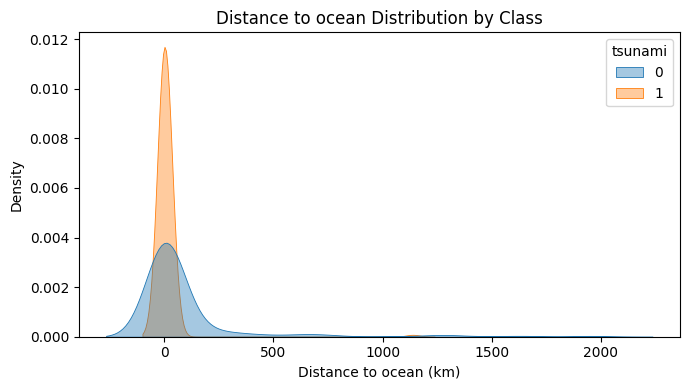

In [27]:
fig, ax = plt.subplots(figsize=(7,4))
sns.kdeplot(
    data=data_df,
    x="distance_to_ocean_km",
    hue="tsunami",
    common_norm=False,
    fill=True,
    alpha=0.4,
    linewidth=0.6,
    ax=ax
)
ax.set_title("Distance to ocean Distribution by Class")
ax.set_xlabel("Distance to ocean (km)")

plt.tight_layout()
plt.show()

This plot shows that the tsunamis happen where distance to coastline is low. Now we can remove 'latitude' and 'longitude' columns from our data
This will remain as a note for us to remember in the modeeling phase.

In [28]:
# data_df = data_df.drop(columns=["latitude", "longitude"])

### Using the time features.
In the current data, the 'Year' and 'Month' columns are not a good identifier for detecting tsunamis. Thus we will try to create better time features. Since earthquakes can trigger other earthquakes in a linear time-line, we can create a new column called 'month_number'.

In [29]:
if ("Year" not in data_df.columns) or ("Month" not in data_df.columns):
    dt_col = next((c for c in ["time","date","datetime"] if c in data_df.columns), None)
    dt = pd.to_datetime(data_df[dt_col], errors="coerce")
    data_df["Year"] = dt.dt.year
    data_df["Month"] = dt.dt.month

data_df["month_number"] = (data_df["Year"] - 2000) * 12 + data_df["Month"]

print(data_df[["Year","Month","month_number"]].head())

   Year  Month  month_number
0  2020     12           252
1  2020     10           250
2  2020     10           250
3  2020      9           249
4  2020      9           249


In [30]:
# Check correlation of month_number with tsunami
work_df = data_df[["month_number", "Year", "Month", "tsunami"]].dropna().copy()
work_df["tsunami"] = work_df["tsunami"].astype(int)
corr_month_number = work_df[["month_number", "tsunami"]].corr().iloc[0,1]
print(f"Correlation month_number-tsunami: {corr_month_number:.4f}")

Correlation month_number-tsunami: 0.0826


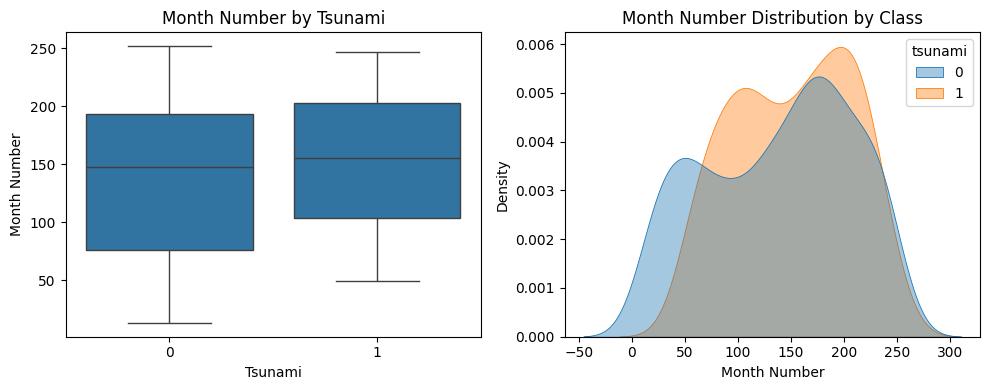

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))
sns.boxplot(data=data_df, x='tsunami', y='month_number', ax=ax[0])
ax[0].set_title('Month Number by Tsunami'); ax[0].set_xlabel('Tsunami'); ax[0].set_ylabel('Month Number')

sns.kdeplot(data=data_df, x='month_number', hue='tsunami', common_norm=False, fill=True, alpha=0.4, linewidth=0.6, ax=ax[1])
ax[1].set_title('Month Number Distribution by Class'); ax[1].set_xlabel('Month Number')

plt.tight_layout()
plt.show()

Still there is no meaningful insight using time features. Time is redundant for determining the tsunamis. So we can remove the time features from our data. This will remain as a note for us to remember in the model part. We can inspect the importance of features with a more comprehansive approach.

In [32]:
# data_df = data_df.drop(columns=["Year", "Month","month_number"])
data_df.head()

,magnitude,cdi,mmi,sig,nst,dmin,gap,depth,latitude,longitude,Year,Month,tsunami,distance_to_ocean_km,month_number
0,6.7,5,5,776,0,1.319,19.0,10.00,-39.3264,-74.9067,2020,12,0,0.0,252
1,7.0,8,7,1527,0,1.518,18.0,21.00,37.8973,26.7953,2020,10,0,0.0,250
2,7.6,9,7,1165,0,0.230,36.0,28.37,54.6620,-159.6750,2020,10,0,0.0,250
3,6.9,0,3,732,0,11.255,16.0,10.00,0.9604,-26.8332,2020,9,0,0.0,249
4,6.5,6,6,674,0,0.388,49.0,16.00,-27.9285,-71.3937,2020,9,0,0.0,249


### In EDA we have observed that dmin and nst features were not properly set.
Since half ot the data points that belongs to nst and dmin are not set correctly, we have to drop those columns. This will also remain as a note for us to remember in the model part.

In [33]:
# data_df = data_df.drop(columns=["dmin", "nst"])
data_df.head()

,magnitude,cdi,mmi,sig,nst,dmin,gap,depth,latitude,longitude,Year,Month,tsunami,distance_to_ocean_km,month_number
0,6.7,5,5,776,0,1.319,19.0,10.00,-39.3264,-74.9067,2020,12,0,0.0,252
1,7.0,8,7,1527,0,1.518,18.0,21.00,37.8973,26.7953,2020,10,0,0.0,250
2,7.6,9,7,1165,0,0.230,36.0,28.37,54.6620,-159.6750,2020,10,0,0.0,250
3,6.9,0,3,732,0,11.255,16.0,10.00,0.9604,-26.8332,2020,9,0,0.0,249
4,6.5,6,6,674,0,0.388,49.0,16.00,-27.9285,-71.3937,2020,9,0,0.0,249


### We have decided which columns should be in the data. Next step is to normalize the data. We should inspect the data and choose the suitable normalization method.

--- Descriptive Statistics ---
                      count        mean         std    min      25%    50%  \
magnitude             700.0    6.941800    0.449614    6.5    6.600    6.8   
cdi                   700.0    4.140000    3.141917    0.0    0.000    5.0   
mmi                   700.0    6.018571    1.412573    1.0    5.000    6.0   
sig                   700.0  867.484286  317.602114  650.0  691.000  751.0   
depth                 700.0   73.200510  132.436261    2.7   14.045   26.0   
distance_to_ocean_km  700.0   83.686306  283.548026    0.0    0.000    0.0   

                             75%      max  
magnitude               7.100000     9.10  
cdi                     7.000000     9.00  
mmi                     7.000000     9.00  
sig                   902.250000  2910.00  
depth                  48.250000   670.81  
distance_to_ocean_km    9.259766  1971.00  


--- Generating Feature Plots ---


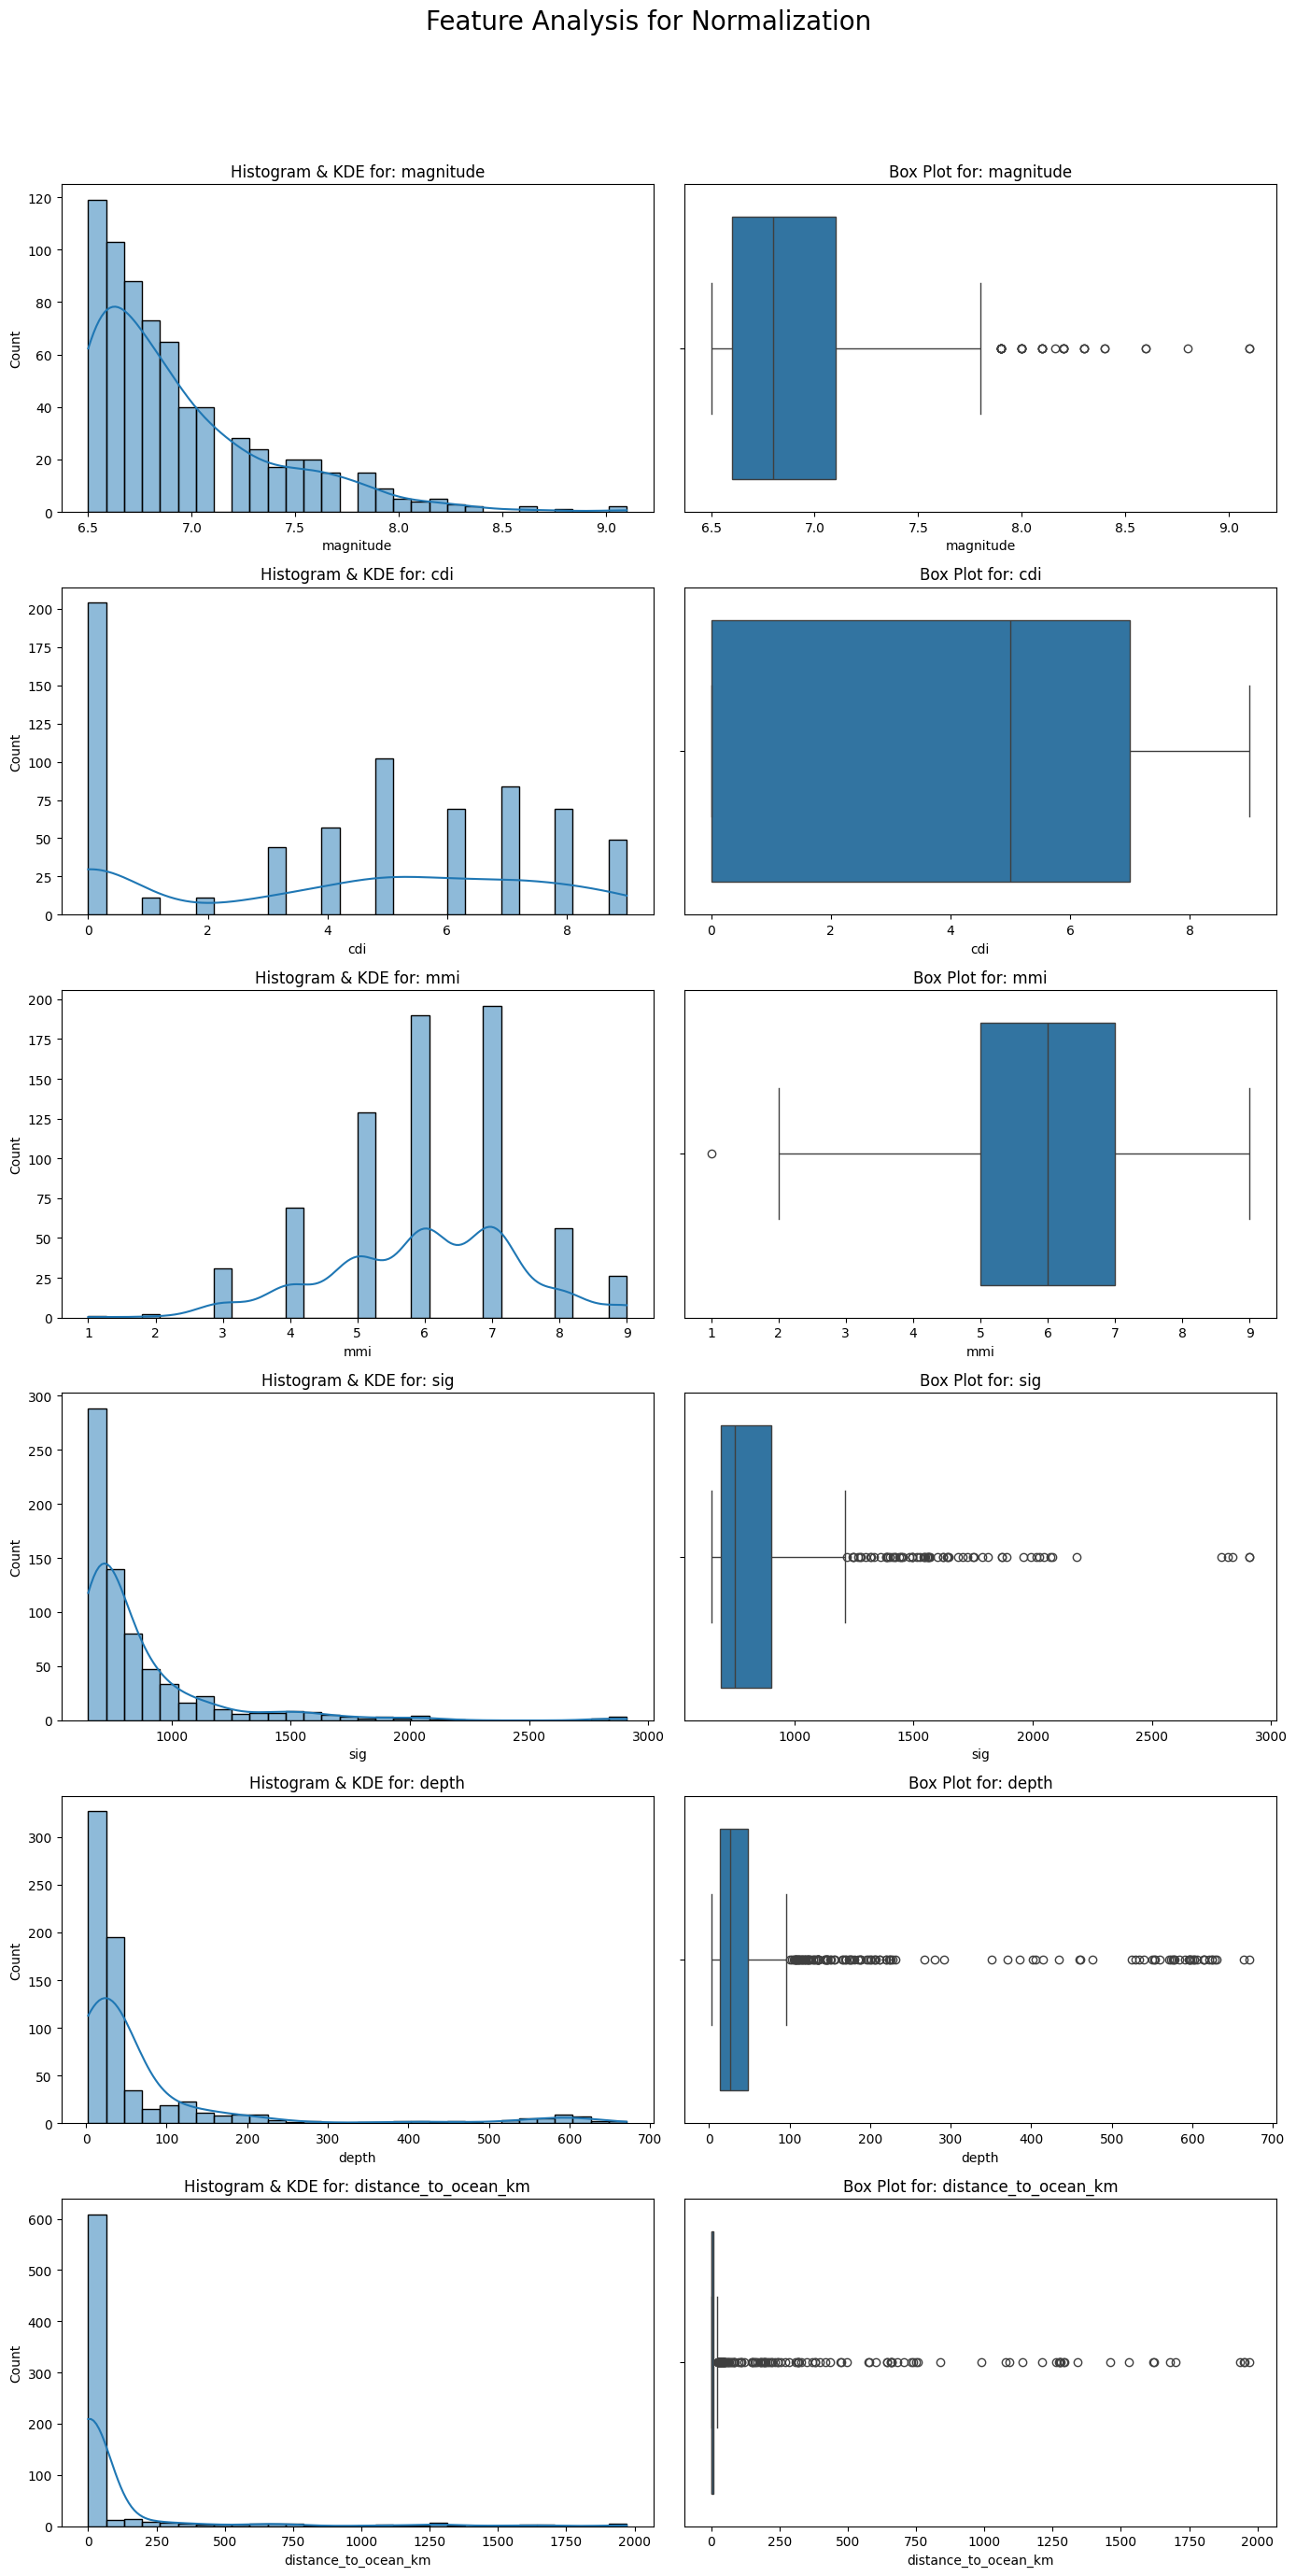

In [34]:
features_to_scale = [
    'magnitude', 
    'cdi', 
    'mmi', 
    'sig', 
    'depth', 
    'distance_to_ocean_km'
]
n_features = len(features_to_scale)

print("--- Descriptive Statistics ---")

print(data_df[features_to_scale].describe().T)
print("\n" + "="*30 + "\n")

print("--- Generating Feature Plots ---")

fig, axes = plt.subplots(n_features, 2, figsize=(14, n_features * 4.5))
fig.suptitle('Feature Analysis for Normalization', fontsize=20, y=1.02)

for i, feature in enumerate(features_to_scale):
    
    sns.histplot(data_df[feature], kde=True, ax=axes[i, 0], bins=30)
    axes[i, 0].set_title(f'Histogram & KDE for: {feature}')
    
    sns.boxplot(x=data_df[feature], ax=axes[i, 1])
    axes[i, 1].set_title(f'Box Plot for: {feature}')

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

Based on the descriptive statistics, a single scaling method is insufficient. The data exhibits two main challenges:

Extreme Right-Skew & Meaningful Outliers: Columns like depth (Mean: 75.8 vs. Median: 26.2) and sig (Max: 2910 vs. 75th %: 909) are heavily skewed. These outliers are meaningful and should not be discarded, but they will "squash" standard linear scalers.

Meaningful Zeros: Columns distance_to_coast_km (Median: 0.0) and cdi (25th %: 0.0) are "zero-inflated," where 0 is a significant value (e.g., "in the ocean") that must be preserved.

The Solution: Two-Step Pipeline
We will apply a two-step Pipeline to all feature columns using a ColumnTransformer. This approach preserves the information from the entire dataset, including outliers and zeros, while making it suitable for a machine learning model.

Step 1: PowerTransformer(method='yeo-johnson')

This is a non-linear transformation that makes the data more Gaussian (bell-shaped).

It "pulls in" the extreme outliers (like 2910 in sig) without ignoring them, solving the skewness problem.

The 'yeo-johnson' method is specifically chosen because it can handle the meaningful zero values in distance_to_coast_km and cdi correctly.

Step 2: StandardScaler()

After the PowerTransformer has normalized the distribution, we can safely apply StandardScaler to center the data at a mean of 0 and a standard deviation of 1.

The tsunami column (the target variable) will be left untouched.

In [35]:
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

features_to_transform = [
    'magnitude', 
    'cdi', 
    'mmi', 
    'sig', 
    'depth', 
    'distance_to_ocean_km'
]

feature_pipeline = Pipeline(steps=[
    ('power_transform', PowerTransformer(method='yeo-johnson')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('transform_and_scale', feature_pipeline, features_to_transform)
    ],
    remainder='passthrough'  # This is crucial: it leaves 'tsunami' alone
)

scaled_data = preprocessor.fit_transform(data_df)

passthrough_features = [col for col in data_df.columns 
                        if col not in features_to_transform]

final_columns = features_to_transform + passthrough_features

scaled_df = pd.DataFrame(scaled_data, columns=final_columns)

In [36]:
print("--- TRANSFORMED AND SCALED DATA ---")
scaled_df.head()

--- TRANSFORMED AND SCALED DATA ---


,magnitude,cdi,mmi,sig,depth,distance_to_ocean_km,nst,dmin,gap,latitude,longitude,Year,Month,tsunami,month_number
0,-0.454008,0.366134,-0.750815,0.042117,-1.273282,-0.641182,0.0,1.319,19.0,-39.3264,-74.9067,2020.0,12.0,0.0,252.0
1,0.480596,1.147295,0.682949,1.802154,-0.271551,-0.641182,0.0,1.518,18.0,37.8973,26.7953,2020.0,10.0,0.0,250.0
2,1.464696,1.387524,0.682949,1.472781,0.067414,-0.641182,0.0,0.230,36.0,54.6620,-159.6750,2020.0,10.0,0.0,250.0
3,0.215003,-1.381760,-2.007214,-0.349174,-1.273282,-0.641182,0.0,11.255,16.0,0.9604,-26.8332,2020.0,9.0,0.0,249.0
4,-1.366553,0.638393,-0.053959,-1.035334,-0.610675,-0.641182,0.0,0.388,49.0,-27.9285,-71.3937,2020.0,9.0,0.0,249.0


In [37]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import fbeta_score



In [38]:
# ...existing code...
def train_catboost(train_df, test_df=None, params=None, n_folds=10, val_size=0.05, early_stopping_rounds=100, verbose=True, use_gpu=True, threshold=0.5):
    """
    Train CatBoost model using StratifiedKFold cross-validation or full training.
    """
    # Identify categorical columns
    cat_cols = list(train_df.select_dtypes(include=['category']).columns)

    # Prepare features and target
    X = train_df.drop(columns='tsunami')
    y = train_df['tsunami'].astype(int)  # ensure 0/1

    if params is None:
        params = {}

    if use_gpu:
        params['task_type'] = 'GPU'
    else:
        params['task_type'] = 'CPU'

    params['thread_count'] = -1
    params['verbose'] = 0
    params['random_state'] = 42

    # Full training mode
    if test_df is not None:
        # Create pools
        train_pool = Pool(X, y, cat_features=cat_cols)

        # Prepare test data
        X_test = test_df.drop(columns='tsunami', errors='ignore')

        # Train model
        model = CatBoostClassifier(**params)
        model.fit(train_pool)

        # Predict on test set
        y_test_probs = model.predict_proba(X_test)[:, 1]

        # Create DataFrame with single column
        y_probs_df = pd.DataFrame({'fold_1': y_test_probs}, index=X_test.index)

        if verbose:
            print("Full training completed")

        return model, y_probs_df

    # Cross-validation mode with StratifiedKFold
    # ...existing code...

    else:
        cv = StratifiedKFold(n_splits=n_folds, random_state=42, shuffle=True)
        cv_scores = []
        oof_predictions = np.zeros(len(X))

        for fold_no, (idx_train, idx_test) in enumerate(cv.split(X, y), 1):
            X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
            X_test, y_test = X.iloc[idx_test], y.iloc[idx_test]

            X_train, X_val, y_train, y_val = train_test_split(
                X_train, y_train, test_size=val_size, stratify=y_train, random_state=42
            )

            train_pool = Pool(X_train, y_train, cat_features=cat_cols)
            valid_pool = Pool(X_val, y_val, cat_features=cat_cols)

            model = CatBoostClassifier(**params)
            model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=early_stopping_rounds)

            y_test_probs = model.predict_proba(X_test)[:, 1]
            oof_predictions[idx_test] = y_test_probs

            # convert probs -> labels with a threshold
            y_test_pred = (y_test_probs >= threshold).astype(int)
            cv_score = fbeta_score(y_test, y_test_pred, beta=2.0, average='binary', zero_division=0)
            cv_scores.append(cv_score)

            if verbose:
                print(f"Fold No: {fold_no}  | Score: {round(cv_score, 3)}")

        # Calculate overall CV and OOF scores
        cv_score = np.mean(cv_scores)
        oof_pred_labels = (oof_predictions >= threshold).astype(int)
        oof_score = fbeta_score(y, oof_pred_labels, beta=2.0, average='binary', zero_division=0)

        if verbose:
            print(25*'*')
            print(f"CV Score: {round(cv_score, 3)}")
            print(f"OOF Score: {round(oof_score, 3)}")

        return model, cv_score, oof_score
# ...existing code...

In [39]:
baseline_model, baseline_cv, baseline_oof = train_catboost(scaled_df, use_gpu=0, verbose=False)
baseline_score = (baseline_cv + baseline_oof) / 2
print(f"Baseline CV: {baseline_cv:.4f} | Baseline OOF: {baseline_oof:.4f} | Baseline Avg: {baseline_score:.4f}")


Baseline CV: 0.5545 | Baseline OOF: 0.5571 | Baseline Avg: 0.5558


In [40]:
import random
from tqdm import tqdm
cols_to_test = [col for col in list(scaled_df.columns) if col != 'tsunami']


lofo_experiment_result = []
for col in tqdm(cols_to_test, desc="LOFO in progress..."):
    train_df_exp = scaled_df.drop(columns=col).copy()
    model, cv_score, oof_score = train_catboost(train_df_exp, use_gpu=0, verbose=False)
    lofo_experiment_result.append({f"{col}": round((cv_score+oof_score)/2, 6)}) # Başarı metriği olarak CV ve OOF skorlarının ortalamasını almayı tercih ettik

lofo_experiment_result

LOFO in progress...: 100%|██████████| 14/14 [01:21<00:00,  5.82s/it]


[{'magnitude': np.float64(0.495441)},
 {'cdi': np.float64(0.563479)},
 {'mmi': np.float64(0.556964)},
 {'sig': np.float64(0.556103)},
 {'depth': np.float64(0.520542)},
 {'distance_to_ocean_km': np.float64(0.494958)},
 {'nst': np.float64(0.537285)},
 {'dmin': np.float64(0.545266)},
 {'gap': np.float64(0.579884)},
 {'latitude': np.float64(0.609875)},
 {'longitude': np.float64(0.542458)},
 {'Year': np.float64(0.557483)},
 {'Month': np.float64(0.577069)},
 {'month_number': np.float64(0.556568)}]

##### Previously we have suggested to drop these columns :
Year, Month, month_number, dmin, nst, longitude, latitude

In [41]:
lofo_experiment_result_df = pd.DataFrame([
    {'feature': list(d.keys())[0],
     'lofo_score': list(d.values())[0]}
    for d in lofo_experiment_result
])

lofo_experiment_result_df = lofo_experiment_result_df.sort_values(by='lofo_score', ascending=False).reset_index(drop=True)
print(f"Baseline was {baseline_cv:.4f}")
lofo_experiment_result_df

Baseline was 0.5545


,feature,lofo_score
0,latitude,0.609875
1,gap,0.579884
2,Month,0.577069
3,cdi,0.563479
4,Year,0.557483
5,mmi,0.556964
6,month_number,0.556568
7,sig,0.556103
8,dmin,0.545266
9,longitude,0.542458


##### Let's check the impact of leaving a feature out on our model.
Out of the suggested columns, dropping the latitude, Month, Year, month_number, dmin columns improved our model. 
Dropping nst or longitude did not result in a meaningful improvement.
After checking this, we can safely leave out these fatures. 


In [42]:
scaled_df = scaled_df.drop(columns=["month_number","Year", "Month","nst","dmin","longitude","latitude"])

The part that needs a mention is that removing 'gap' feature resulted in an unexpected improvement. We will keep that in mind while creating our models.

In [43]:
scaled_data_path = Path("../data/processed/earthquake_data_tsunami_scaled.csv")
scaled_df.to_csv(scaled_data_path, index=False)